In [10]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

In [2]:
def simulate_network_data(num_samples, num_stations):
    data = []
    network_types = ["Wi-Fi", "4G", "5G", "Satellite"]
    
    for i in range(num_samples):
        record = {"Timestamp": f"2024-01-01 00:00:{i}"}
        record["Current_Station"] = np.random.randint(0, num_stations)  # Current station index
        
        for station in range(num_stations):
            record[f"Station_{station}_Signal"] = np.random.uniform(-100, 0)  # dBm
            record[f"Station_{station}_Latency"] = np.random.uniform(1, 300)  # ms
            record[f"Station_{station}_Bandwidth"] = np.random.uniform(1, 1000)  # Mbps
            record[f"Station_{station}_Type"] = np.random.choice(network_types)
        
        data.append(record)
    return pd.DataFrame(data)

# Generate Dataset
NUM_SAMPLES = 500
NUM_STATIONS = 5
df = simulate_network_data(NUM_SAMPLES, NUM_STATIONS)

# Save dataset for reference
df.to_csv("synthetic_network_handoff.csv", index=False)
print("CSV file saved.")

CSV file saved.


In [3]:
# Define fuzzy variables (placeholders; will be updated dynamically)
signal_strength = ctrl.Antecedent(np.arange(-100, 1, 1), 'signal_strength')
latency = ctrl.Antecedent(np.arange(1, 301, 1), 'latency')
bandwidth = ctrl.Antecedent(np.arange(1, 1001, 1), 'bandwidth')
suitability = ctrl.Consequent(np.arange(0, 101, 1), 'suitability')

# Initial Membership functions (will be overridden by GA)
signal_strength['weak'] = fuzz.trapmf(signal_strength.universe, [-100, -100, -70, -50])
signal_strength['moderate'] = fuzz.trimf(signal_strength.universe, [-70, -50, -30])
signal_strength['strong'] = fuzz.trapmf(signal_strength.universe, [-50, -30, 0, 0])

latency['high'] = fuzz.trapmf(latency.universe, [200, 250, 300, 300])
latency['medium'] = fuzz.trimf(latency.universe, [100, 200, 300])
latency['low'] = fuzz.trapmf(latency.universe, [0, 0, 100, 150])

bandwidth['low'] = fuzz.trapmf(bandwidth.universe, [0, 0, 250, 500])
bandwidth['medium'] = fuzz.trimf(bandwidth.universe, [250, 500, 750])
bandwidth['high'] = fuzz.trapmf(bandwidth.universe, [500, 750, 1000, 1000])

suitability['poor'] = fuzz.trapmf(suitability.universe, [0, 0, 25, 50])
suitability['average'] = fuzz.trimf(suitability.universe, [25, 50, 75])
suitability['excellent'] = fuzz.trapmf(suitability.universe, [50, 75, 100, 100])

# Define initial fuzzy rules
rules = [
    ctrl.Rule(signal_strength['strong'] & latency['low'] & bandwidth['high'], suitability['excellent']),
    ctrl.Rule(signal_strength['moderate'] & latency['medium'] & bandwidth['medium'], suitability['average']),
    ctrl.Rule(signal_strength['weak'] | latency['high'] | bandwidth['low'], suitability['poor']),
]

# Initialize fuzzy control system
handoff_control = ctrl.ControlSystem(rules)
handoff_simulator = ctrl.ControlSystemSimulation(handoff_control)

In [4]:
# ----------------------------- #
# 3. Handoff Decision Simulation  #
# ----------------------------- #

def fuzzy_handoff_decision(record, station, simulator):
    simulator.input['signal_strength'] = record[f"Station_{station}_Signal"]
    simulator.input['latency'] = record[f"Station_{station}_Latency"]
    simulator.input['bandwidth'] = record[f"Station_{station}_Bandwidth"]

    # Perform the simulation
    simulator.compute()
    return simulator.output['suitability']

def simulate_fuzzy_handoff(df, num_stations, simulator):
    results = []

    for index, record in df.iterrows():
        current_station = record["Current_Station"]
        current_type = record[f"Station_{current_station}_Type"]
        best_station = current_station
        best_suitability = -float('inf')
        best_type = current_type
        
        for station in range(num_stations):
            try:
                suitability = fuzzy_handoff_decision(record, station, simulator)
                if suitability > best_suitability:
                    best_station = station
                    best_suitability = suitability
                    best_type = record[f"Station_{station}_Type"]
            except KeyError:
                continue  # Stick with the current station if a KeyError occurs
        
        # Determine handoff type
        if best_station == current_station:
            handoff_type = "No Handoff"
        elif best_type == current_type:
            handoff_type = f"Horizontal Handoff to Station {best_station}"
        else:
            handoff_type = f"Vertical Handoff to Station {best_station}"
        
        results.append({
            "Timestamp": record["Timestamp"],
            "Current_Station": current_station,
            "Current_Type": current_type,
            "Best_Station": best_station,
            "Best_Type": best_type,
            "Handoff_Type": handoff_type,
            "Suitability_Score": best_suitability
        })
        if (index + 1) % 50 == 0 or index == 0:
            print(f"Processed {index + 1}/{len(df)} records.")
    
    return pd.DataFrame(results)

# Simulate with initial fuzzy logic
print("Simulating with initial fuzzy logic system...")
initial_results = simulate_fuzzy_handoff(df, NUM_STATIONS, handoff_simulator)

# Save initial results
initial_results.to_csv("fuzzy_handoff_initial_results.csv", index=False)
print("Initial fuzzy logic results saved to 'fuzzy_handoff_initial_results.csv'.")

Simulating with initial fuzzy logic system...
Processed 1/500 records.
Processed 50/500 records.
Processed 100/500 records.
Processed 150/500 records.
Processed 200/500 records.
Processed 250/500 records.
Processed 300/500 records.
Processed 350/500 records.
Processed 400/500 records.
Processed 450/500 records.
Processed 500/500 records.
Initial fuzzy logic results saved to 'fuzzy_handoff_initial_results.csv'.


In [8]:
def plot_fuzzy_results(results):
    plt.figure(figsize=(10, 6))
    
    # Plotting Suitability Scores
    plt.subplot(1, 2, 1)
    plt.hist(results['Suitability_Score'], bins=20, color='blue', edgecolor='black')
    plt.title('Distribution of Suitability Scores')
    plt.xlabel('Suitability Score')
    plt.ylabel('Frequency')
    
    # Plotting Hand-off Types
    plt.subplot(1, 2, 2)
    handoff_types = results['Handoff_Type'].value_counts()
    handoff_types.plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Handoff Types Distribution')
    plt.xlabel('Handoff Type')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

In [5]:
# ------------------------------ #
# 4. Genetic Algorithm Integration #
# ------------------------------ #

# Genetic Algorithm Parameters
POPULATION_SIZE = 5 # 20
GENERATIONS = 10 # 30
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
NUM_PARAMETERS = 6  # 2 for signal_strength, 2 for latency, 2 for bandwidth
VARIABLE_BOUNDS = [
    (-100, -50),  # signal_strength weak to moderate
    (-70, 0),     # signal_strength moderate to strong
    (0, 150),     # latency low to medium
    (100, 300),   # latency medium to high
    (0, 500),     # bandwidth low to medium
    (250, 1000)    # bandwidth medium to high
]

# Initialize population
def initialize_population(size, num_parameters, bounds):
    population = []
    for _ in range(size):
        individual = []
        for (low, high) in bounds:
            individual.append(random.uniform(low, high))
        population.append(np.array(individual))
    return population

# Decode individual into membership function boundaries
def decode_individual(individual):
    signal_bounds = individual[:2]   # [weak to moderate, moderate to strong]
    latency_bounds = individual[2:4] # [low to medium, medium to high]
    bandwidth_bounds = individual[4:6] # [low to medium, medium to high]
    return signal_bounds, latency_bounds, bandwidth_bounds

# Update fuzzy logic system with new membership function boundaries
# Update fuzzy logic system with new membership function boundaries
def update_fuzzy_membership(signal_bounds, latency_bounds, bandwidth_bounds):
    # Ensure the bounds are sorted to maintain validity
    signal_bounds = sorted(signal_bounds)
    latency_bounds = sorted(latency_bounds)
    bandwidth_bounds = sorted(bandwidth_bounds)
    
    # Update Signal Strength Membership Functions
    signal_strength['weak'] = fuzz.trapmf(signal_strength.universe, [-100, -100, signal_bounds[0], min(signal_bounds[0] + 20, -50)])
    signal_strength['moderate'] = fuzz.trimf(signal_strength.universe, [max(signal_bounds[0], -70), signal_bounds[1], min(signal_bounds[1] + 20, 0)])
    signal_strength['strong'] = fuzz.trapmf(signal_strength.universe, [max(signal_bounds[1], -50), min(signal_bounds[1] + 20, 0), 0, 0])

    # Update Latency Membership Functions
    latency_low_b = min(latency_bounds[0] + 50, 150)
    latency_med_b = min(latency_bounds[1] + 50, 300)
    latency['low'] = fuzz.trapmf(latency.universe, [0, 0, latency_bounds[0], latency_low_b])
    latency['medium'] = fuzz.trimf(latency.universe, [max(latency_bounds[0], 50), latency_bounds[1], latency_med_b])
    
    # Ensure `latency['high']` parameters maintain the order a <= b <= c <= d
    latency_high_a = max(latency_bounds[1], 200)
    latency_high_b = max(latency_high_a, min(latency_bounds[1] + 50, 300))  # Ensure b >= a
    latency['high'] = fuzz.trapmf(latency.universe, [latency_high_a, latency_high_b, 300, 300])

    # Update Bandwidth Membership Functions
    bandwidth_low_b = min(bandwidth_bounds[0] + 250, 500)
    bandwidth_med_b = min(bandwidth_bounds[1] + 250, 1000)
    bandwidth['low'] = fuzz.trapmf(bandwidth.universe, [0, 0, bandwidth_bounds[0], bandwidth_low_b])
    bandwidth['medium'] = fuzz.trimf(bandwidth.universe, [max(bandwidth_bounds[0], 250), bandwidth_bounds[1], bandwidth_med_b])
    
    # Ensure `bandwidth['high']` parameters maintain the order a <= b <= c <= d
    bandwidth_high_a = max(bandwidth_bounds[1], 500)
    bandwidth_high_b = max(bandwidth_high_a, min(bandwidth_bounds[1] + 250, 1000))  # Ensure b >= a
    bandwidth['high'] = fuzz.trapmf(bandwidth.universe, [bandwidth_high_a, bandwidth_high_b, 1000, 1000])

# Define fuzzy rules (remain constant)
def define_fuzzy_rules():
    rules = [
        ctrl.Rule(signal_strength['strong'] & latency['low'] & bandwidth['high'], suitability['excellent']),
        ctrl.Rule(signal_strength['moderate'] & latency['medium'] & bandwidth['medium'], suitability['average']),
        ctrl.Rule(signal_strength['weak'] | latency['high'] | bandwidth['low'], suitability['poor']),
    ]
    return rules

# Fitness function
def evaluate_fitness(individual, df, num_stations):
    # Decode individual's parameters
    signal_bounds, latency_bounds, bandwidth_bounds = decode_individual(individual)
    
    # Update membership functions
    update_fuzzy_membership(signal_bounds, latency_bounds, bandwidth_bounds)
    
    # Define rules
    rules = define_fuzzy_rules()
    
    # Rebuild fuzzy control system
    handoff_control = ctrl.ControlSystem(rules)
    handoff_simulator = ctrl.ControlSystemSimulation(handoff_control)
    
    # Run simulation
    results = simulate_fuzzy_handoff(df, num_stations, handoff_simulator)
    
    # Calculate fitness based on average suitability score and minimizing unnecessary handoffs
    avg_suitability = results['Suitability_Score'].mean()
    total_handoffs = (results['Handoff_Type'] != "No Handoff").sum()
    
    # Define fitness: higher average suitability and fewer handoffs are better
    fitness = avg_suitability - (total_handoffs * 0.1)  # Adjust penalty as needed
    
    return fitness

# Crossover
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, NUM_PARAMETERS - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return child1, child2
    return parent1.copy(), parent2.copy()

# Mutation
def mutate(individual):
    for i in range(NUM_PARAMETERS):
        if random.random() < MUTATION_RATE:
            # Apply small mutation
            mutation = random.uniform(-10, 10)
            individual[i] += mutation
            # Ensure bounds
            individual[i] = max(VARIABLE_BOUNDS[i][0], min(VARIABLE_BOUNDS[i][1], individual[i]))
    return individual

# Selection (Tournament Selection)
def select_population(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# Genetic Algorithm
def genetic_algorithm(df, num_stations):
    # Initialize population
    population = initialize_population(POPULATION_SIZE, NUM_PARAMETERS, VARIABLE_BOUNDS)
    
    # Track best solution
    best_individual = None
    best_fitness = -float('inf')
    
    for generation in range(GENERATIONS):
        # Evaluate fitness
        fitnesses = [evaluate_fitness(ind, df, num_stations) for ind in population]
        
        # Find the best individual in the current generation
        gen_best_fitness = max(fitnesses)
        gen_best_individual = population[np.argmax(fitnesses)]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = gen_best_individual.copy()
        
        print(f"Generation {generation+1}: Best Fitness = {gen_best_fitness:.2f}")
        
        # Selection
        selected_population = select_population(population, fitnesses)
        
        # Create next generation
        next_generation = []
        for i in range(0, POPULATION_SIZE, 2):
            parent1 = selected_population[i]
            parent2 = selected_population[min(i+1, POPULATION_SIZE-1)]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            next_generation.extend([child1, child2])
        
        population = next_generation[:POPULATION_SIZE]
    
    print("Genetic Algorithm Optimization Complete.")
    print("Best Fitness:", best_fitness)
    print("Best Individual:", best_individual)
    return best_individual

In [6]:
# ------------------------------ #
# 5. Run Genetic Algorithm and Optimize Fuzzy Logic #
# ------------------------------ #

# Run Genetic Algorithm to find optimized membership function boundaries
print("Starting Genetic Algorithm Optimization...")
optimized_params = genetic_algorithm(df, NUM_STATIONS)

# Decode optimized parameters
signal_bounds_opt, latency_bounds_opt, bandwidth_bounds_opt = decode_individual(optimized_params)

# Update membership functions with optimized parameters
update_fuzzy_membership(signal_bounds_opt, latency_bounds_opt, bandwidth_bounds_opt)

# Define rules (after updating membership functions)
rules_opt = define_fuzzy_rules()

# Rebuild fuzzy control system with optimized rules
handoff_control_opt = ctrl.ControlSystem(rules_opt)
handoff_simulator_opt = ctrl.ControlSystemSimulation(handoff_control_opt)

print("Optimized Fuzzy Logic System Configured.")

Starting Genetic Algorithm Optimization...
Processed 1/500 records.
Processed 50/500 records.
Processed 100/500 records.
Processed 150/500 records.
Processed 200/500 records.
Processed 250/500 records.
Processed 300/500 records.
Processed 350/500 records.
Processed 400/500 records.
Processed 450/500 records.
Processed 500/500 records.
Processed 1/500 records.
Processed 50/500 records.
Processed 100/500 records.
Processed 150/500 records.
Processed 200/500 records.
Processed 250/500 records.
Processed 300/500 records.
Processed 350/500 records.
Processed 400/500 records.
Processed 450/500 records.
Processed 500/500 records.
Processed 1/500 records.
Processed 50/500 records.
Processed 100/500 records.
Processed 150/500 records.
Processed 200/500 records.
Processed 250/500 records.
Processed 300/500 records.
Processed 350/500 records.
Processed 400/500 records.
Processed 450/500 records.
Processed 500/500 records.
Processed 1/500 records.
Processed 50/500 records.
Processed 100/500 record

In [7]:
# ------------------------------ #
# 6. Run Simulation with Optimized Fuzzy Logic #
# ------------------------------ #

# Define a new fuzzy handoff decision function for optimized system
def fuzzy_handoff_decision_opt(record, station, simulator):
    simulator.input['signal_strength'] = record[f"Station_{station}_Signal"]
    simulator.input['latency'] = record[f"Station_{station}_Latency"]
    simulator.input['bandwidth'] = record[f"Station_{station}_Bandwidth"]

    # Perform the simulation
    simulator.compute()
    return simulator.output['suitability']

def simulate_fuzzy_handoff_opt(df, num_stations, simulator):
    results = []

    for index, record in df.iterrows():
        current_station = record["Current_Station"]
        current_type = record[f"Station_{current_station}_Type"]
        best_station = current_station
        best_suitability = -float('inf')
        best_type = current_type
        
        for station in range(num_stations):
            try:
                suitability = fuzzy_handoff_decision_opt(record, station, simulator)
                if suitability > best_suitability:
                    best_station = station
                    best_suitability = suitability
                    best_type = record[f"Station_{station}_Type"]
            except KeyError:
                continue  # Stick with the current station if a KeyError occurs
        
        # Determine handoff type
        if best_station == current_station:
            handoff_type = "No Handoff"
        elif best_type == current_type:
            handoff_type = f"Horizontal Handoff to Station {best_station}"
        else:
            handoff_type = f"Vertical Handoff to Station {best_station}"
        
        results.append({
            "Timestamp": record["Timestamp"],
            "Current_Station": current_station,
            "Current_Type": current_type,
            "Best_Station": best_station,
            "Best_Type": best_type,
            "Handoff_Type": handoff_type,
            "Suitability_Score": best_suitability
        })
        if (index + 1) % 50 == 0 or index == 0:
            print(f"Processed {index + 1}/{len(df)} records.")
    
    return pd.DataFrame(results)

# Run simulation with optimized fuzzy logic
optimized_results = simulate_fuzzy_handoff_opt(df, NUM_STATIONS, handoff_simulator_opt)

# Save optimized results
optimized_results.to_csv("optimized_fuzzy_handoff_results.csv", index=False)
print("Optimized handoff results saved.")
print("Fuzzy handoff simulation with optimized parameters complete.")

Processed 1/500 records.
Processed 50/500 records.
Processed 100/500 records.
Processed 150/500 records.
Processed 200/500 records.
Processed 250/500 records.
Processed 300/500 records.
Processed 350/500 records.
Processed 400/500 records.
Processed 450/500 records.
Processed 500/500 records.
Optimized handoff results saved.
Fuzzy handoff simulation with optimized parameters complete.


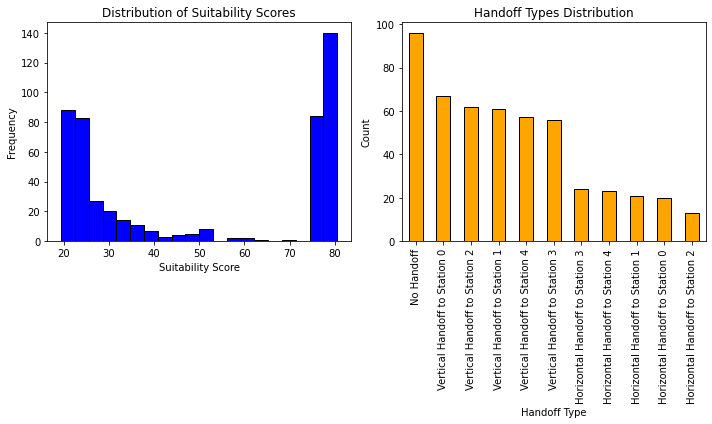

In [12]:
plot_fuzzy_results(initial_results)

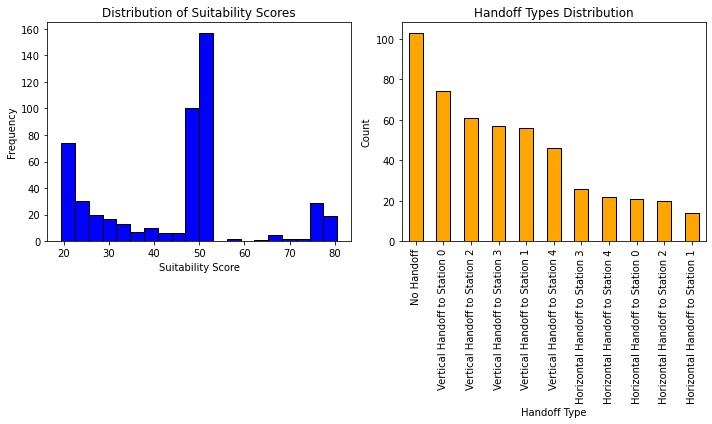

In [14]:
plot_fuzzy_results(optimized_results) # pop = 5, gens = 10

# This shift demonstrates that the genetic algorithm enhanced the 
# system's ability to make more balanced and practical handoff 
# decisions that aren't overly biased toward ideal conditions, 
# which would be more applicable in a real-world network environment.